In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression  # For comparison
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFE

In [202]:
# 1. Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Datasets/forestfires.csv")


In [203]:
# (a) Data Cleaning
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("\nDuplicates after removal:", df.duplicated().sum())

Missing Values:
 X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Duplicates: 4

Duplicates after removal: 0


In [204]:
# (b) Summary Statistics
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
                 X           Y        FFMC         DMC          DC         ISI  \
count  513.000000  513.000000  513.000000  513.000000  513.000000  513.000000   
mean     4.678363    4.300195   90.637427  110.989279  549.155166    9.023587   
std      2.320059    1.230925    5.540920   64.191013  247.724594    4.575543   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  440.900000    6.400000   
50%      4.000000    4.000000   91.600000  108.300000  664.500000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   11.000000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  513.000000  513.000000  513.000000  513.000000   513.000000  
mean    18.887524   44.348928    4.010526    0.021832    12.891598  
std      5.828128   16.358803    1.796613

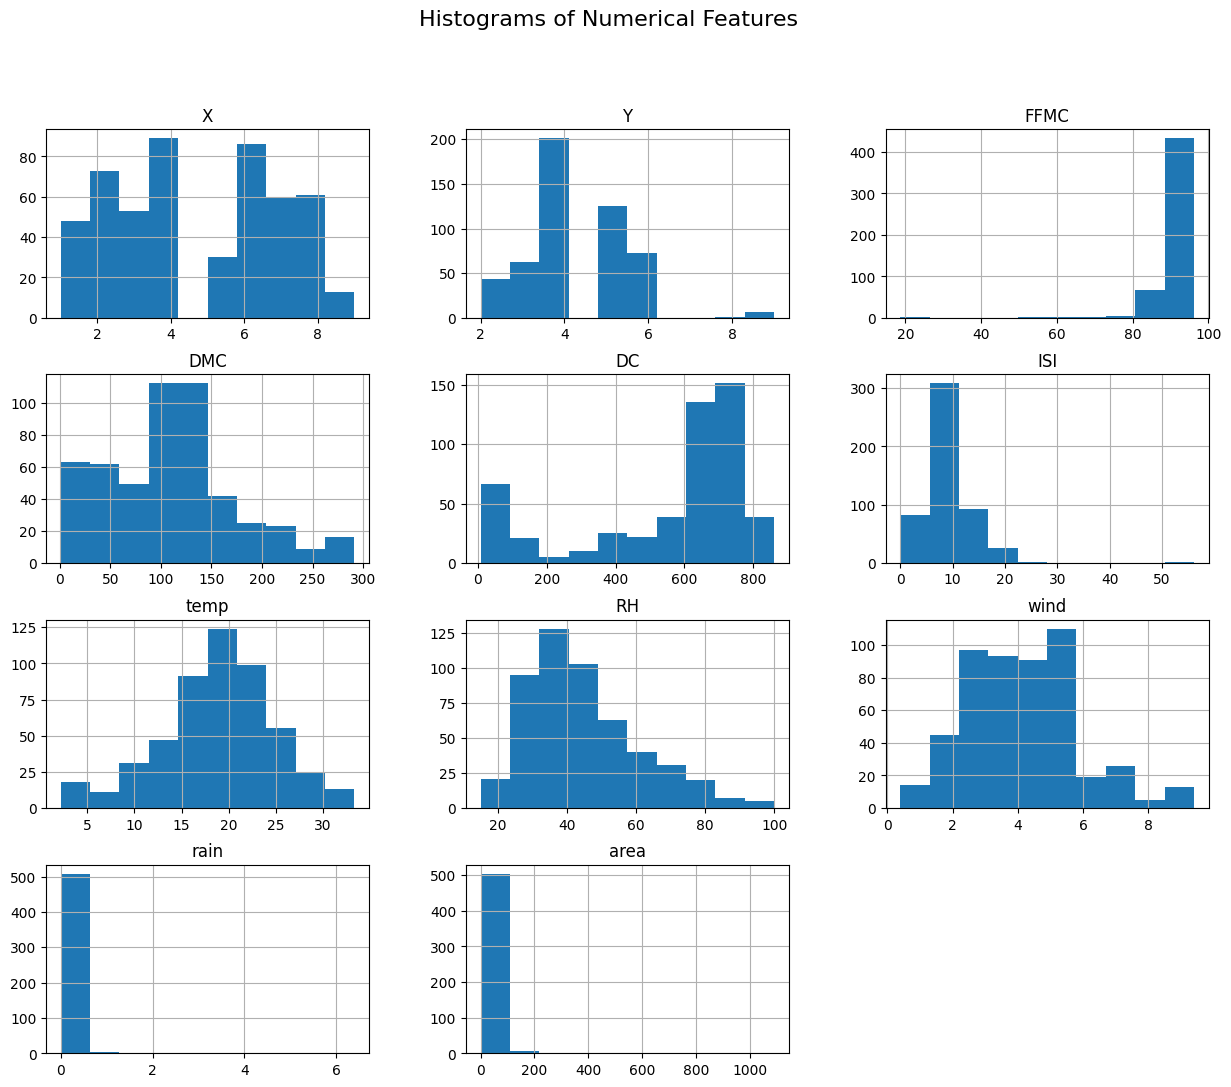

In [205]:
# (c) Visualizations
# Histograms
df.hist(figsize=(15, 12))
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

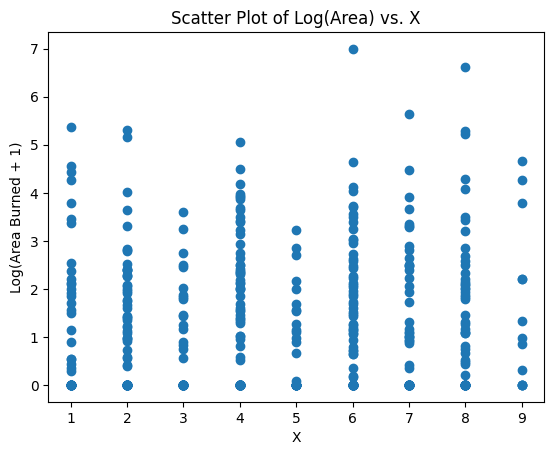

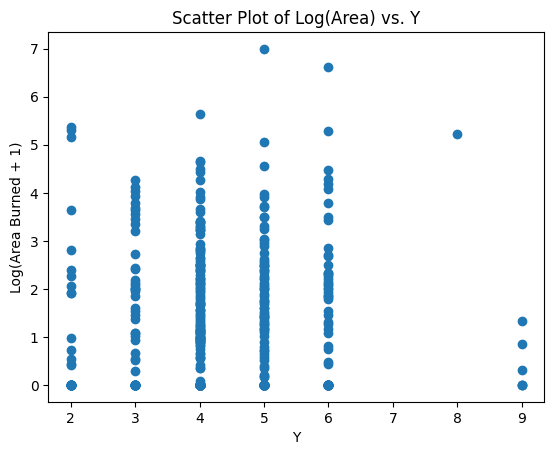

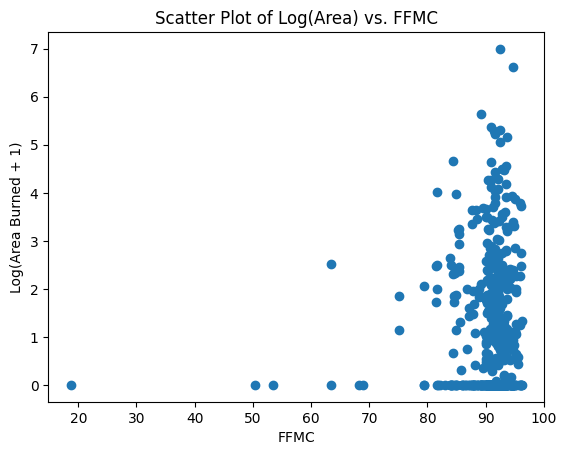

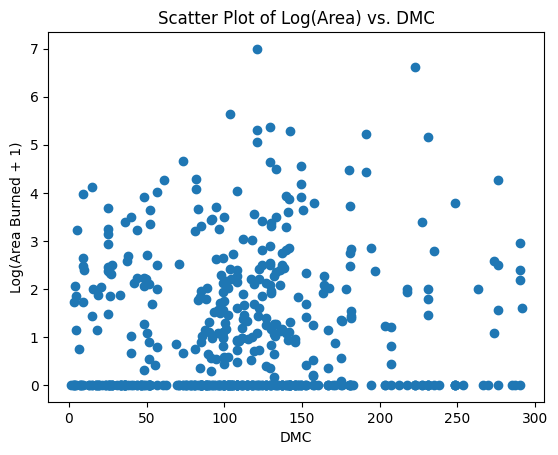

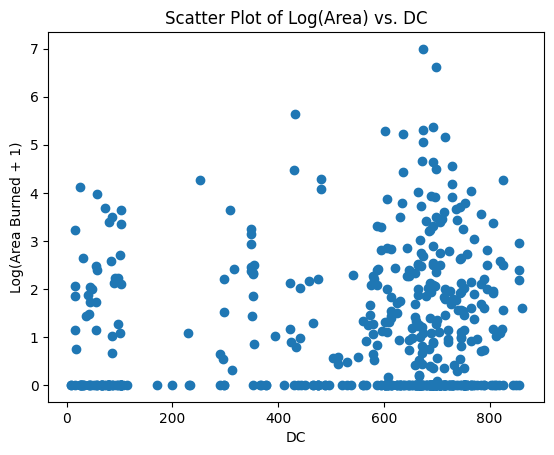

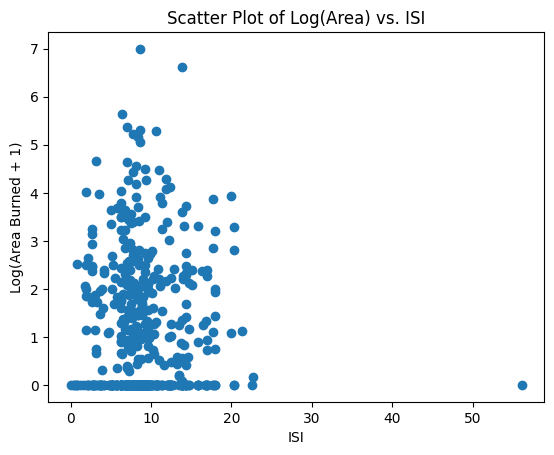

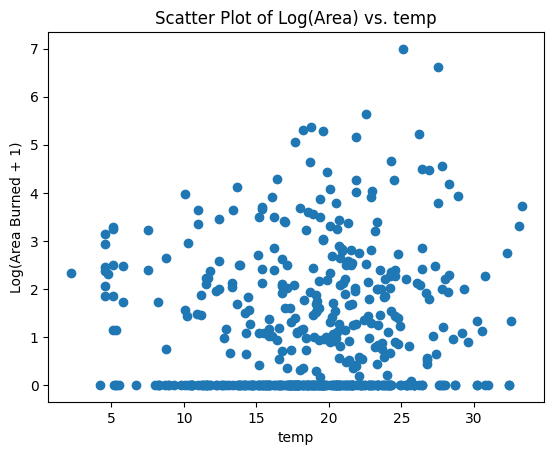

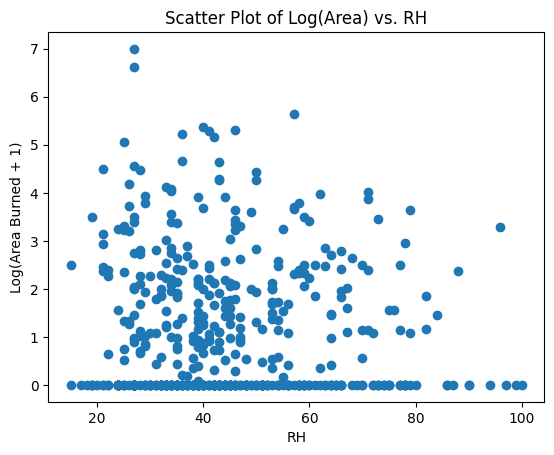

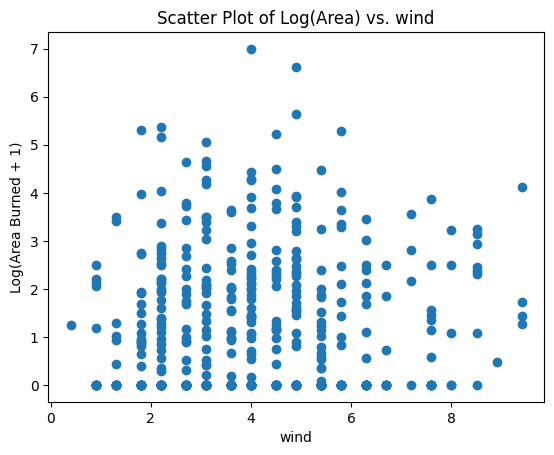

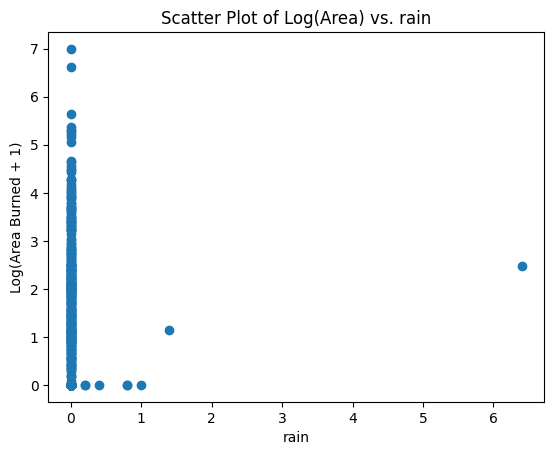

In [219]:
# Scatter plots (Target vs. Features)
for feature in ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']:
    plt.figure()
    plt.scatter(df[feature], np.log1p(df['area']))  # Log transform area
    plt.xlabel(feature)
    plt.ylabel('Log(Area Burned + 1)')
    plt.title(f'Scatter Plot of Log(Area) vs. {feature}')

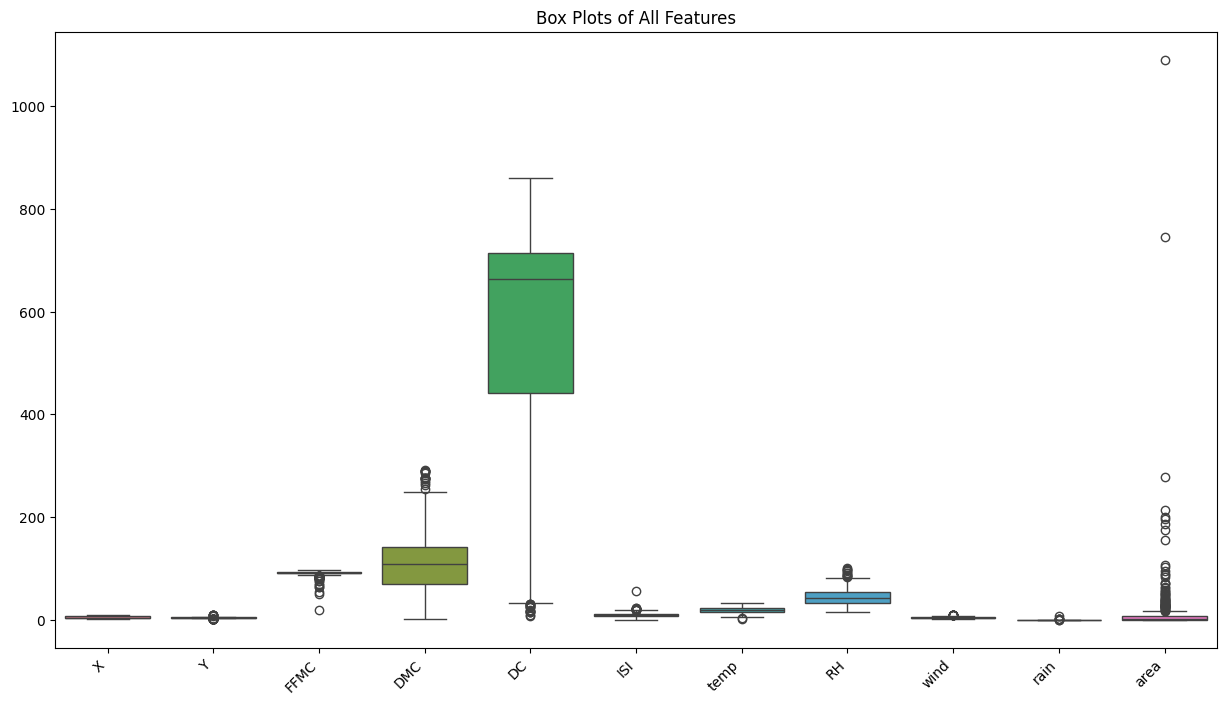

In [207]:
# Box plots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45, ha='right')
plt.title("Box Plots of All Features")
plt.show()

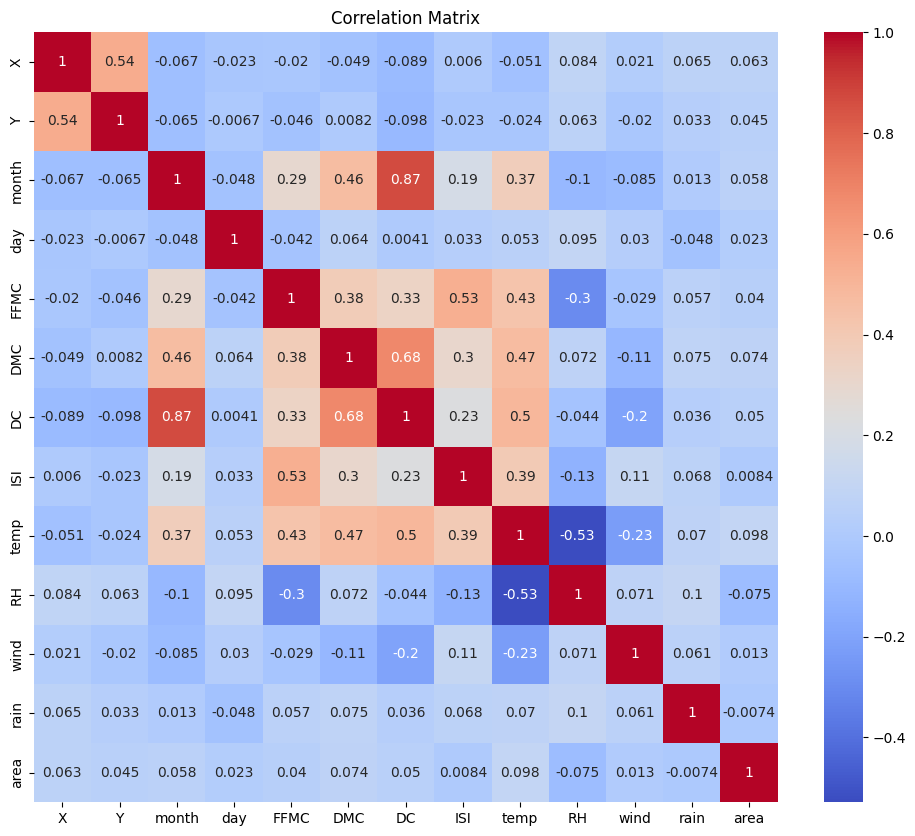

In [208]:
# Convert 'month' and 'day' columns to numerical representations
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}

df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)

# Now calculate the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

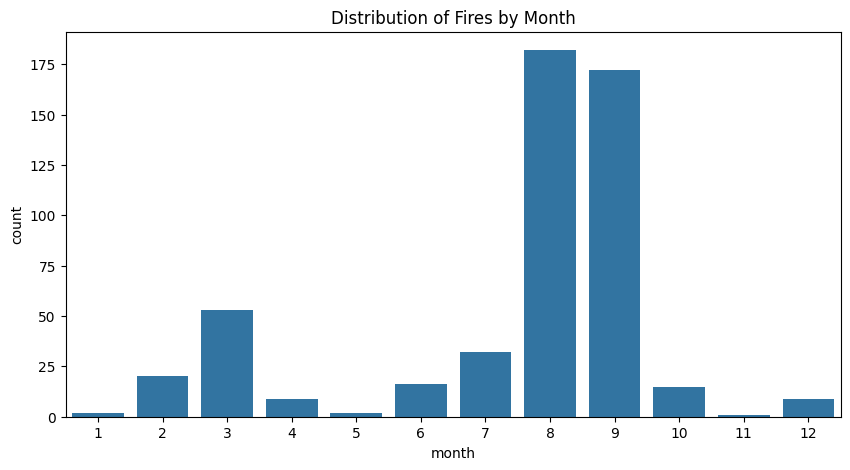

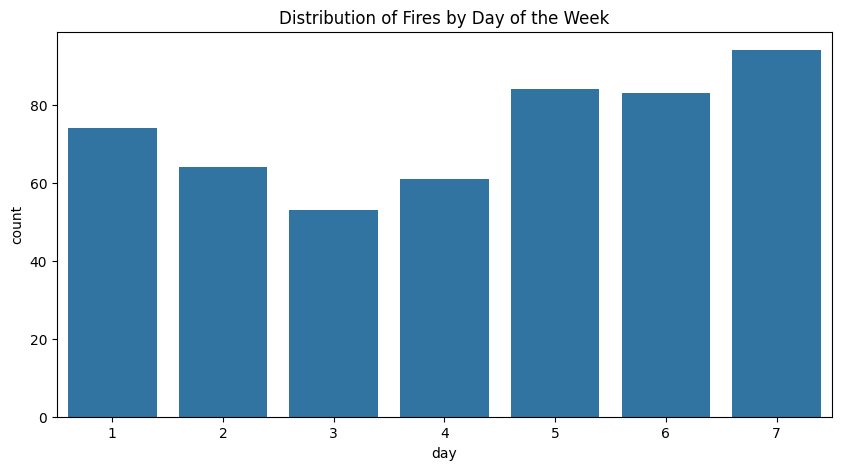

In [209]:
# Categorical Variable Analysis
plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=df)
plt.title('Distribution of Fires by Month')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='day', data=df)
plt.title('Distribution of Fires by Day of the Week')
plt.show()

In [210]:
# 2. Preprocessing and Data Split
categorical_features = ['month', 'day']
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)])

X = df.drop('area', axis=1)
y = np.log1p(df['area'])  # Log transform target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [211]:
class MyLinearRegression:
    """
    A simple implementation of linear regression using gradient descent.
    """

    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the training data.

        Args:
            X: The training features (NumPy array).
            y: The training target values (NumPy array).
        """

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            y_predicted = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        """
        Predicts target values for new data.

        Args:
            X: The new features (NumPy array).

        Returns:
            The predicted target values (NumPy array).
        """

        return np.dot(X, self.weights) + self.bias

In [212]:
# 4. Model Building and Evaluation
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a regression model using Mean Squared Error (MSE) and R-squared.

    Args:
        model: The trained regression model.
        X_test: The test features.
        y_test: The test target values.

    Returns:
        A tuple containing the MSE and R-squared values.
    """

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    return mse, r2

In [213]:
# Model 1: Linear Regression (From scratch)
my_lr = MyLinearRegression(learning_rate=0.01, n_iterations=1000) #Adjust learning rate and n_iterations
X_train_transformed = preprocessor.fit_transform(X_train) #Fit and transform training data
X_test_transformed = preprocessor.transform(X_test) #Transform test data
my_lr.fit(X_train_transformed, y_train.values) #Fit the model
y_pred_my_lr = my_lr.predict(X_test_transformed)
mse_my_lr, r2_my_lr = evaluate_model(my_lr, X_test_transformed, y_test)
print("\nMy Linear Regression:", f"MSE: {mse_my_lr:.4f}", f"R-squared: {r2_my_lr:.4f}")

Mean Squared Error: 1.6140
R-squared: 0.0339

My Linear Regression: MSE: 1.6140 R-squared: 0.0339


In [214]:
# Model 2: Linear Regression (Scikit-learn - for comparison)
pipeline_lr = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipeline_lr.fit(X_train, y_train)
mse_lr, r2_lr = evaluate_model(pipeline_lr, X_test, y_test)
print("\nScikit-learn Linear Regression:", f"MSE: {mse_lr:.4f}", f"R-squared: {r2_lr:.4f}")

Mean Squared Error: 1.6048
R-squared: 0.0394

Scikit-learn Linear Regression: MSE: 1.6048 R-squared: 0.0394


In [215]:
# Model 3: Random Forest
pipeline_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])
pipeline_rf.fit(X_train, y_train)
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_test, y_test)
print("\nRandom Forest (Initial):", f"MSE: {mse_rf:.4f}", f"R-squared: {r2_rf:.4f}")


Mean Squared Error: 1.7913
R-squared: -0.0723

Random Forest (Initial): MSE: 1.7913 R-squared: -0.0723


In [216]:
# 5. Hyperparameter Tuning (Random Forest)
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
} # Added closing curly brace

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_
print("\nBest Random Forest Hyperparameters:", grid_search_rf.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Random Forest Hyperparameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}


In [217]:
# 6. Feature Selection (Random Forest)
selector_rf = SelectKBest(f_regression, k=5)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_selected_rf = selector_rf.fit_transform(X_train_transformed, y_train)
X_test_selected_rf = selector_rf.transform(X_test_transformed)

# Get feature names after transformation
feature_names_transformed = preprocessor.get_feature_names_out()

# Get selected feature indices
selected_feature_indices = selector_rf.get_support(indices=True)

# Get selected feature names
selected_features_rf = [feature_names_transformed[i] for i in selected_feature_indices]

print("\nSelected Features for Random Forest:", selected_features_rf)


Selected Features for Random Forest: ['cat__month_3', 'cat__month_9', 'cat__month_12', 'num__X', 'num__temp']


In [218]:
# 7. Final Model (Random Forest)
final_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', best_rf_model.named_steps['regressor']) # Access the regressor from best_rf_model
])

# Fit the final pipeline directly to the original training data (DataFrame)
final_rf_pipeline.fit(X_train, y_train)

mse_rf_final, r2_rf_final = evaluate_model(final_rf_pipeline, X_test, y_test)
print("\nFinal Random Forest:", f"MSE: {mse_rf_final:.4f}", f"R-squared: {r2_rf_final:.4f}")

Mean Squared Error: 1.7359
R-squared: -0.0391

Final Random Forest: MSE: 1.7359 R-squared: -0.0391
